In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [152]:
# os.chdir("/data/jake/csci_7000-final_project")
os.chdir('/home/jake/ghub/csci-7000-006-neurosymbolic-nlp')

In [153]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
d_tensor_1kg

{'NA18614': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01918': tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32),
 'NA18546': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02855': tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32),
 'HG03565': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19324': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20527': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19107': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01162': tensor([1, 2, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02885': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA21126': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG00132': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20332': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19087': tensor([1, 1, 1,  ..., 2, 1, 1], dtype=torch.int32),
 'HG02035': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG03785': tensor([1, 1,

In [154]:
# scale to pdist range
for k,v in d_tensor_1kg.items():
    s = torch.sum(v)
    d_tensor_1kg[k] = v/s

In [155]:
# set tensor to float 32
for k,v in d_tensor_1kg.items():
    d_tensor_1kg[k] = v.to(torch.float32)

In [156]:
df_target = pd.read_csv("1kg-g2g_l2.tsv", sep="\t")
df_target.head()

,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


- Q: is it better to scale the target vector or leave as is?
- **If scaled**, make sure to transform the embedding distance computed by the model while computing loss (see MSELoss).

<Axes: >

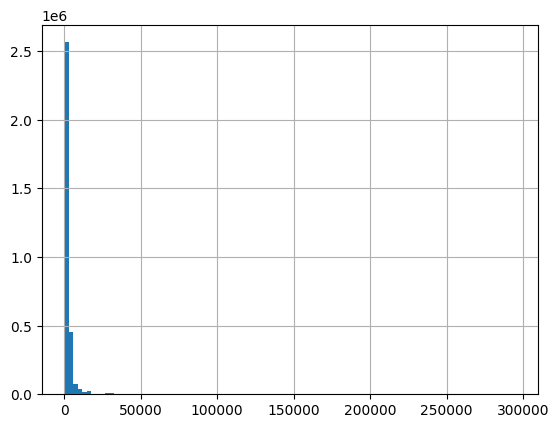

In [157]:
df_target['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


<Axes: >

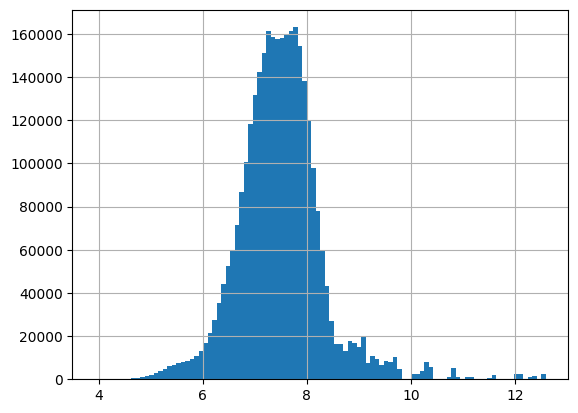

In [158]:
df_target['l2_log'] = df_target['l2'].apply(lambda x: np.log(x+1))
# apply standard scaler
# scaler = StandardScaler()
# df_target['l2_z_log'] = scaler.fit_transform(df_target['l2_z_log'].values.reshape(-1,1))
# df_target['l2_z_log'].hist(bins=100)
print(df_target.head())
df_target['l2_log'].hist(bins=100)

In [159]:
class SiameseDataset(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset
        # len(d_tensor), but this is a lot of data per epoch
        self.n_samples = n_samples
        self.scaled_target = scaled_target

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        pair = self.df_target.sample(1)
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

- Quick method for hold out

In [160]:
df_target_test = df_target.sample(1000, random_state=0)
# exclude test from train
# df_target_train = df_target[~df_target.index.isin(df_target_test.index)]
# print(len(df_target_train), len(df_target_test), len(df_target))

- Note: A less stringent approach could be employed

It could be allowed that any sample can be seen during training, yet not allowing for an 
exact pair in the test data set to be seen during training.

- However, I'm using the stringent approach of excluding any sample in the test pairs from the training data

In [161]:
test_samples = pd.concat([df_target_test['s_i'], df_target_test['s_j']]).unique()
test_samples.shape

(1395,)

In [162]:
# filter out test samples
df_target_train = df_target[~df_target['s_i'].isin(test_samples) & ~df_target['s_j'].isin(test_samples)]
print(len(df_target_train), len(df_target_test), len(df_target))
# show that the test samples are not in the train set
print(pd.concat([df_target_train['s_i'], df_target_train['s_j']]).nunique(), len(test_samples))
df_target_train.head()

649230 1000 3211845
1140 1395


,l2,s_i,s_j,l2_log
0,2099.0,NA18614,HG01918,7.649693
1,2988.0,NA18614,NA18546,8.002694
2,1381.0,NA18614,HG02855,7.231287
3,1468.0,NA18614,HG03565,7.292337
5,1670.0,NA18614,NA20527,7.421178


In [163]:
# no need to subset the tensor dictionary since we sample from the target dataframe
# which is paritioned for training samples only
dataset = SiameseDataset(d_tensor_1kg, df_target_train, n_samples=1000,scaled_target=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [167]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    def forward_one(self, x):
        # compute embedding
        return self.fc(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2
class CustomMSELoss(nn.Module):
    def __init__(self, scaled_target=True):
        super(CustomMSELoss, self).__init__()
        self.scaled_target = scaled_target

    def forward(self, embedding_distance, target_distance):
        if self.scaled_target:
            embedding_distance = torch.log10(embedding_distance + 1)
            loss = torch.mean((embedding_distance - target_distance) ** 2)
        loss = torch.mean((embedding_distance - target_distance) ** 2)
        return loss

In [168]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

18721 512


In [169]:
torch.set_num_threads(15) # using gpu, but set this just in case
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1)
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
    print(f"Epoch {epoch+1}, loss: {running_loss}")

Epoch 1, batch 1, loss: 59.990440368652344
Epoch 1, batch 2, loss: 56.989845275878906
Epoch 1, batch 3, loss: 58.06481170654297
Epoch 1, batch 4, loss: 58.250274658203125
Epoch 1, batch 5, loss: 57.2374267578125
Epoch 1, batch 6, loss: 54.148033142089844
Epoch 1, batch 7, loss: 54.99231719970703
Epoch 1, batch 8, loss: 56.72591018676758
Epoch 1, batch 9, loss: 58.39344787597656
Epoch 1, batch 10, loss: 55.35999298095703
Epoch 1, batch 11, loss: 59.956912994384766
Epoch 1, batch 12, loss: 55.525184631347656
Epoch 1, batch 13, loss: 58.59491729736328
Epoch 1, batch 14, loss: 56.68809509277344
Epoch 1, batch 15, loss: 54.24500274658203
Epoch 1, batch 16, loss: 54.177154541015625
Epoch 1, loss: 909.3397674560547
Epoch 2, batch 1, loss: 59.919288635253906
Epoch 2, batch 2, loss: 57.893028259277344
Epoch 2, batch 3, loss: 55.80242919921875
Epoch 2, batch 4, loss: 55.96294021606445
Epoch 2, batch 5, loss: 54.33269500732422
Epoch 2, batch 6, loss: 55.58300018310547
Epoch 2, batch 7, loss: 55.6

- Since all test samples were excluded, any combination of test samples can be used for evaluation at inference time
- For practical purposes, choose 1000 pairs ground truth versus predicted

In [79]:
df_target_test = df_target[(df_target['s_i'].isin(test_samples)) & (df_target['s_j'].isin(test_samples))]
print(df_target_test.shape)
df_target_test.head()

(972315, 3)


,l2,s_i,s_j
12663,739.0,NA19324,HG02885
12664,1874.0,NA19324,NA21126
12665,1935.0,NA19324,HG00132
12668,178.0,NA19324,HG02035
12669,211.0,NA19324,HG03785


In [83]:
df_target_test_sub = df_target_test.sample(1000, random_state=0)
print(df_target_test_sub.shape)
df_target_test_sub.head()

(1000, 3)


,l2,s_i,s_j
539629,4587.0,NA19213,NA19431
2023457,1780.0,HG00737,HG01843
2276963,2391.0,HG02471,HG03108
1279172,2511.0,HG02108,NA19378
1403012,815.0,NA20778,HG02819


In [84]:
# inference on test pairs
model.eval()
for i, row in df_target_test_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.sum((output1 - output2) ** 2)
    print(f"Pair: {s1}, {s2}, target: {row['l2']}, distance: {embedding_distance.item()}")

Pair: NA19213, NA19431, target: 4587.000000000001, distance: 1138.9765625
Pair: HG00737, HG01843, target: 1780.0000000000002, distance: 14.665517807006836
Pair: HG02471, HG03108, target: 2391.0, distance: 893.100830078125
Pair: HG02108, NA19378, target: 2511.0, distance: 71.16474914550781
Pair: NA20778, HG02819, target: 815.0, distance: 65.31532287597656
Pair: NA12282, NA19436, target: 1515.0, distance: 476.4280700683594
Pair: HG02582, NA20898, target: 3851.0, distance: 1548.69189453125
Pair: HG00177, HG03730, target: 1606.0000000000002, distance: 201.3794708251953
Pair: HG04035, HG01052, target: 1812.0, distance: 405.0400695800781
Pair: NA20344, HG03867, target: 242.0, distance: 2.81160306930542
Pair: HG03240, HG02339, target: 1683.0, distance: 110.59719848632812
Pair: HG01776, HG00332, target: 1357.9999999999998, distance: 534.718994140625
Pair: HG02078, HG03873, target: 1657.0, distance: 677.58349609375
Pair: HG03686, HG02381, target: 1060.9999999999998, distance: 259.24462890625
Pa

KeyboardInterrupt: 